In [14]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

## 순환 뉴런과 순환 층

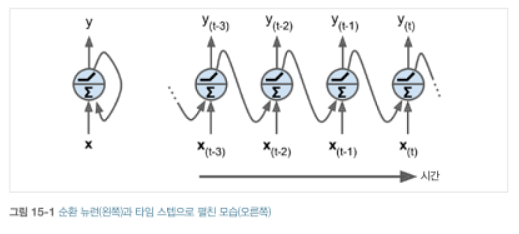

In [1]:
# 순환 신경망은 피드포워드 신경망과 비슷하지만 뒤쪽으로 순환하는 연결도 있다는 점에서 다르다.

# 타임스텝 t(or 프레임)마다 순환뉴런은 x(t) 와 이전 타임 스탭의 출력인 y(t-1)을 입력으로 받는다.
#(첫번째 타임스탭에서는 이전 출력이 없으므로 일반적으로 0으로 설정한다.)

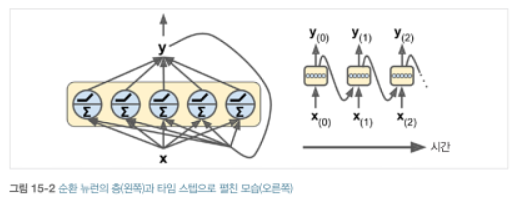

In [2]:
# 타임스탭 t 마다 모든 뉴런은 입력벡터 x(t)와 이전타임 스탭의 출력벡터 y(t-1)을 받는다

# 각 순환 뉴런은 두 벌의 가중치를 갖는다.
## 하나는 입력 x(t)를 위한 것이고, 다른 하나는 이전 타임스텝의 출력 y(t-1)을 위한 것이다.
## Y(t) = ReLU(X(t) * Wx + Y(t-1) * Wy + b)

## Y(t)는 X(t)와 Y(t-1)의 함수다.
## Y(t-1)은 X(t-1) 과 Y(t-2)의 함수다
## Y(t-2)은 X(t-2) 와 Y(t-3)의 함수다 ...
### 결국 Y(t)는 시간 t= 0에서 부터 모든 입력에 대한 함수가 된다.

### 메모리 셀

In [3]:
# 타임 스탭 t 에서 순환 뉴런의 출력은 이전 타임 스텝의 모든 입력에 대한 함수이므로,
## 이를 일종의 메모리 형태라고 말할 수 있다.
## 타임 스텝에 걸쳐 어떤 상태를 보존하는 신경망의 구성요소를 메모리 셀 이라고 한다.
## (하나의 순환 뉴런 또는 순환 뉴런의 층은 짧은 패턴(10스텝 길이 정도)만 학습할 수 있는 매우 기본적인 셀이다.)
### 셀 == layer

# 일반적으로 타입스텝 t에서의 셀의 상태 h(t)는 그 타임스텝의 입력과 이전 타임스텝의 상태에 대한 함수이다.
## h = f(h(t-1), X(t))

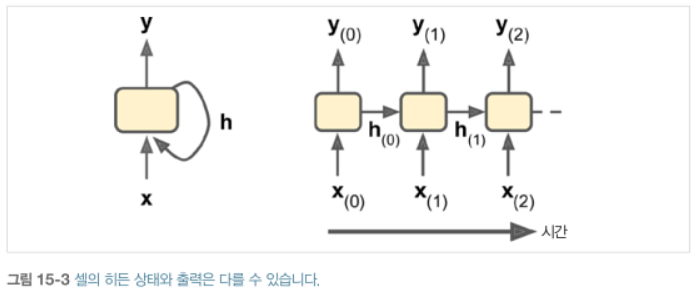

### 입력과 출력 시퀀스

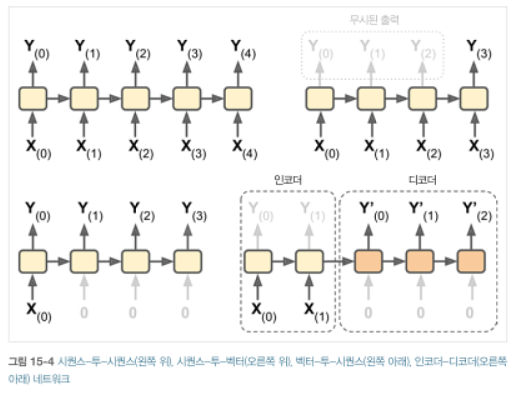

In [4]:
# RNN은 입력 시퀀스를 받아 출력 시퀀스를 만들 수 있다.

# 왼쪽 위의 네트워크는 시퀀스 투 시퀀스 네트워크로 시계열 데이터를 예측하는데 유용하다.

# 오른쪽 위의 네트워크는 시퀀스 투 벡터 네트워크로 입력 시퀀스를 네트워크에 주입하고,
## 마지막을 제외한 모든 출력을 무시한다.

# 왼쪽 아래 네트워크는 벡터 투 시퀀스 네트워크로 각 타임 스탭에서 하나의 입력 벡터를 반복해서 네트워크에 주입하고,
## 하나의 시퀀스를 출력할 수 있다.

# 오른쪽 아래 네트워크는 인코더 라 부르는 시퀀스 투 벡터 네트워크 뒤에
## 디코더 라 부르는 벡터 투 시퀀스 네트워크를 연결할 수 있다.

## RNN 훈련하기

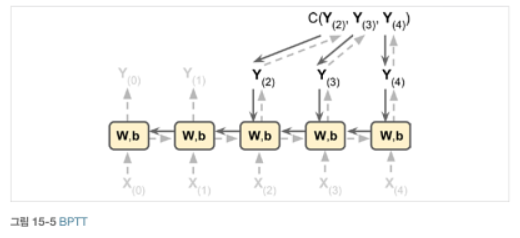

In [ ]:
# BPTT( backpropagation through time )
## 타임스텝으로 네트워크를 펼치고, 보통의 역전파를 사용하는 것이다.

# 1. 정방향 패스가 펼쳐진 네트워크를 통과한다.
# 2. 비용함수 C를 사용하여 출력 시퀀스가 평가된다. (일부 출력을 무시할 수 있다.)
# 3. 비용함수의 기울기가 펼쳐진 네트워크를 따라 역방향으로 전파된다.
# ==> BPTT 동안 계산된 기울기를 사용하여 모델파라미터가 업데이트 된다.

## 시계열 예측하기

In [5]:
import tensorflow
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt


In [8]:
# 시간당 접속 사용자의 수, 도시의 날짜별 온도 ... 처럼
# 데이터가 타임 스텝마다 하나 이상의 값을 가진 시퀀스를 시계열이라고 부른다.

def generate_time_series(batch_size, n_steps):
  freq1, freq2, offsets1, offsets2 = np.random.rand(4,batch_size,1)
  time = np.linspace(0,1,n_steps)
  series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))
  series += 0.2 * np.sin((time - offsets2) * (freq1 * 20 + 20))
  series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
  return series[... , np.newaxis].astype(np.float32)
  # 요청한 만큼 n_steps 길이의 여러 시계열을 만든다.
  # [배치크기 , 타임스텝수, 1]크기의 넘파이 배열을 반환한다.

  ## 시계열을 다룰때 입력특성은 일반적으로 [배치크기, 타임스텝수, 차원 수] 크기의 3D 배열로 나타난다.
  ## 단변량 시계열은 dimensionality 가 1, 다변량 시계열은 1 이상이 된다.

In [9]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
# X_train 은 7000개의 시계열을 담고 있다. [7000, 50 , 1]
# 각 시계열마다 하나의 값을 예측해야 하기 때문에  y_train 은 [7000,1] 크기이다.
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test , y_test = series[9000: , :n_steps], series[9000: , -1]

### 기준 성능

In [10]:
# naive forecasting
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid , y_pred))
# 기준 성능을 준비해두면 실제 모델과의 성능을 비교할 수 있다.
# 가장 간단한 방법은 각 시계열의 마지막 값을 그대로 예측하는 것이다.
## => 순진한 예측 (naive forecasting)
# 가끔 이 성능을 뛰어넘는 것이 매우 어렵다. 이 경우에는 MSE 는 0.020 이다.

0.020530958

### 간단한 RNN 구현하기

In [11]:
model = keras.models.Sequential([
  keras.layers.SimpleRNN(1, input_shape=[None, 1])
  # 하나의 뉴런으로 이루어진 하나의 층을 가진다.
  # RNN은 어떤 길이의 타임 스텝도 처리할 수 있기 때문에 입력 시퀀스의 길이를 지정할 필요가 없다.
])

# 기본적으로 SimpleRNN 층은 tanh 활성화 함수를 사용한다.

In [12]:
optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
# RNN의 순환 뉴런은 입력과 은닉 상태 차원 마다 하나의 파라미터를 가지고, 편향이 있다.
# 기본 RNN 에서는 총 3개의 파라미터가 있다.

Epoch 1/20
219/219 [==============================] - 3s 8ms/step - loss: 0.0162 - val_loss: 0.0115
Epoch 2/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0114 - val_loss: 0.0114
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0112 - val_loss: 0.0114
Epoch 4/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0113 - val_loss: 0.0115
Epoch 5/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0110 - val_loss: 0.0115
Epoch 6/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0114 - val_loss: 0.0114
Epoch 7/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0112 - val_loss: 0.0115
Epoch 8/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0114 - val_loss: 0.0114
Epoch 9/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0114 - val_loss: 0.0114
Epoch 10/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0112 - val_loss: 0.0114

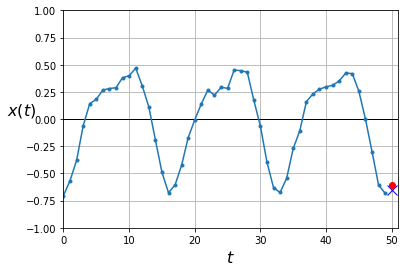

In [16]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### 심층 RNN

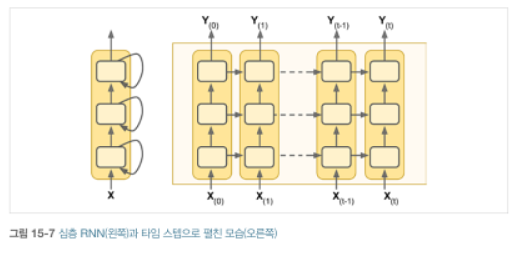

In [17]:
# RNN은 셀을 여러 층으로 쌓는 것이 일반적이다. 이렇게 만든 것이 심층 RNN 이다.
model = keras.models.Sequential([
  keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
  # return_sequences = True로 지정하여 타임 스텝마다 출력을 반환한다.
  # 사용하지 않으면 마지막 스텝의 출력만 담은 2D 배열이 출력되고,
  # 다음 순환 층이 3D 형태로 시퀀스를 받지 못하기 때문에 동작하지 않는다.
  keras.layers.SimpleRNN(20, return_sequences=True),
  keras.layers.SimpleRNN(1)
])

In [18]:
optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 7s 25ms/step - loss: 0.0232 - val_loss: 0.0033
Epoch 2/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 3/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 4/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 5/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 6/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 7/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 8/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 9/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 10/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0026 - val_lo

In [20]:
model = keras.models.Sequential([
  keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
  keras.layers.SimpleRNN(20),
  # return_sequences = True 제거
  keras.layers.Dense(1)
])

# 마지막 층의 SimpleRNN 을 Dense 층으로 바꿈.
# RNN 모델의 마지막 층 은닉 상태는 크게 필요치 않고, 다른 활성화 함수를 사용할 수 있음.

In [21]:
optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
# 마지막 층을 SimpleRNN으로 구성한 것 보다 속도가 더 빠름

Epoch 1/20
219/219 [==============================] - 5s 18ms/step - loss: 0.0592 - val_loss: 0.0034
Epoch 2/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 3/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 4/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 5/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 6/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 7/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 8/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 9/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 10/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0025 - val_lo

### 여러 타임 스텝 앞을 예측하기

In [22]:
series = generate_time_series(1, n_steps + 10)
X_new , Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
  y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis,:]
  X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

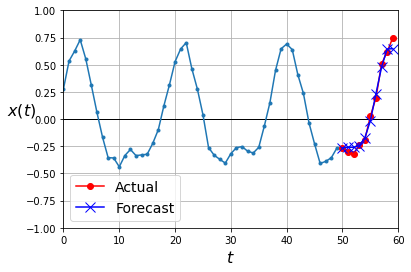

In [24]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)

plt.show()
# 다음 스탭에 대한 예측은 보통 더 미래의 타임 스텝에 대한 예측보다 정확하다.
# 미래의 타임 스텝은 오차가 누적될 수 있기 때문이다.

In [25]:
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000: , :n_steps], series[:7000, -10: , 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10 : ,0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10 : ,0]

In [30]:
model = keras.models.Sequential([
  keras.layers.SimpleRNN(20, return_sequences=True, input_shape = [None, 1]),
  keras.layers.SimpleRNN(20),
  keras.layers.Dense(10)
])

In [31]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 18ms/step - loss: 0.0909 - val_loss: 0.0320
Epoch 2/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0252 - val_loss: 0.0159
Epoch 3/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0153 - val_loss: 0.0122
Epoch 4/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0119 - val_loss: 0.0102
Epoch 5/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0092 - val_loss: 0.0084
Epoch 6/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0079 - val_loss: 0.0068
Epoch 7/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0067 - val_loss: 0.0063
Epoch 8/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0060 - val_loss: 0.0054
Epoch 9/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 10/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0047 - val_lo

In [36]:
Y = np.empty((10000, n_steps, 10))
for step_ahead in range (1, 10 + 1):
  Y[:, :, step_ahead -1] = series[:, step_ahead : step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [37]:
model = keras.models.Sequential([
  keras.layers.SimpleRNN(20, return_sequences=True , input_shape= [None, 1]),
  keras.layers.SimpleRNN(20, return_sequences=True),
  keras.layers.TimeDistributed(keras.layers.Dense(10))
])